# Предсказание цен подержаных автомобилей на американском рынке

**Цель:** разработать модель предсказания стоимости автомобиля на вторичном рынке.   

**Данные:**  
`year` - год выпуска автомобиля;  
`make` - марка автомобиля;  
`model` - модель автомобиля определенной марки;  
`trim` - уровни отделки салона автомобиля;    
`body` - тип кузова;   
`transmission` - тип коробки передач;   
`vin` - идентификационый номер транспортного средства;  
`state` - штат;  
`condition` - состояние автомобиля на момент аукциона;    
`odometer` - расстояние, пройденное автомобилем с момента выпуска;  
`color` - цвет кузова автомобиля;  
`interior` - цвет салона автомобиля;  
`seller` - продавец автомобиля, автосалоны;   
`sellingprice` - цена, по которой автомобиль был продан на аукционе;   
`saledate` - дата продажи автомобиля.





<a id='contence'></a>

## Содержание  
1. [Загрузка и ознакомление с данными](#step1) 
2. [Подготовка и анализ данных](#step2).   
4. [Подготовка итоговых признаков для обучения модели](#step3)  
5. [Обучение моделей и формирование предсказаний](#step4)  
7. [Вывод по исследованию](#step6)


In [1]:
import warnings

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

In [3]:
warnings.filterwarnings("ignore")

In [4]:
RANDOM_STATE = 42

<a id='step1'></a>
## 1. Загрузка и ознакомление с данными
[К содержанию](#contence)

In [5]:
data = pd.read_csv('used-cars-price-prediction-19ds/train.csv', index_col='vin')

In [6]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))
    display(data.shape)

In [7]:
get_data_info(data)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
vin,,,,,,,,,,,,,,
1c3cdzcg5dn740638,2013,Dodge,Avenger,SXT,Sedan,automatic,tx,4.1,35770.0,blue,black,avis corporation,12800,Wed Jan 07 2015 10:15:00 GMT-0800 (PST)
1g1zt62894f209446,2004,Chevrolet,Malibu Maxx,LS,Hatchback,automatic,oh,2.0,174180.0,burgundy,tan,select remarketing group llc/loan max title,1750,Tue Feb 10 2015 04:00:00 GMT-0800 (PST)
3vwsk69m63m159244,2003,Volkswagen,Jetta,GLS,Sedan,automatic,pa,2.0,162686.0,silver,beige,purple heart,750,Tue Jan 13 2015 13:01:00 GMT-0800 (PST)
wdbsk75fx4f064699,2004,Mercedes-Benz,SL-Class,SL500,convertible,automatic,fl,3.3,157997.0,white,beige,land rover palm beach,9200,Thu Jun 04 2015 02:15:00 GMT-0700 (PDT)
1gtw7fca7e1912588,2014,GMC,Savana Cargo,2500,van,automatic,pa,2.9,8863.0,white,gray,u-haul,19000,Fri Jun 19 2015 02:00:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
Index: 440236 entries, 2fmdk3jc4bba41556 to jn8as5mt9dw038107
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   state         440236 non-null  object 
 7   condition     430831 non-null  float64
 8   odometer      440167 non-null  float64
 9   color         439650 non-null  object 
 10  interior      439650 non-null  object 
 11  seller        440236 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 50.4+ MB


None

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
count,440236.000000,432193,432113,431899,429843,388775,440236,430831.000000,440167.000000,439650,439650,440236,440236.000000,440236
unique,NaN,92,959,1922,85,2,38,NaN,NaN,20,17,13025,NaN,3597
top,NaN,Ford,Altima,Base,Sedan,automatic,fl,NaN,NaN,black,black,nissan-infiniti lt,NaN,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,NaN,73708,15454,43853,157639,375061,65618,NaN,NaN,87115,192442,15823,NaN,4209
mean,2010.040101,NaN,NaN,NaN,NaN,NaN,NaN,3.425077,68344.421604,NaN,NaN,NaN,13592.209588,NaN
std,3.977945,NaN,NaN,NaN,NaN,NaN,NaN,0.949973,53542.203908,NaN,NaN,NaN,9751.479098,NaN
min,1982.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN
25%,2007.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.700000,28258.000000,NaN,NaN,NaN,6900.000000,NaN
50%,2012.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.600000,52098.000000,NaN,NaN,NaN,12100.000000,NaN
75%,2013.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.200000,99272.000000,NaN,NaN,NaN,18200.000000,NaN


(440236, 14)

Нам доступны данные о 440236 наблюдениях.
Целевой признак - sellingprice.  
Остальные признаки в основном категориальные, числовые признаки - odometer, condition, year.  
Идентификационный номер транспортного средства уникален для каждого автомобиля и не поможет в задаче прогнозирования, его сделали индексом, ориентируясь на формат sample_submission.  

Столбец с датой продажи логично перевести в формат datetime.

In [8]:
data['saledate'] = pd.to_datetime(data['saledate'], utc=True)

При первичном обзоре данных было видно, что многие столбцы содержат пропуски. Посмотрим, сколько их в процентном соотношении.

In [9]:
pd.DataFrame(round(data.isna().mean()*100), columns=['pct_missing_values']).style.background_gradient('plasma')

,pct_missing_values
year,0.000000
make,2.000000
model,2.000000
trim,2.000000
body,2.000000
transmission,12.000000
state,0.000000
condition,2.000000
odometer,0.000000
color,0.000000


Больше всего пропусков содержит столбец с информацией о типе коробки передач (12%).
По 2% пропусков содержат столбцы с информацией о производителе, модели, уровне отделки салона, типе кузова и состоянии автомобиля на момент продажи.

In [10]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено.  
Обработка скрытых дубликатов и заполнение пропусков будет проведено в ходе подготовки и анализа данных. 

<a id='step2'></a>  
## 2. Подготовка и анализ данных
[К содержанию](#contence)

Поскольку в наших данных сравнительно небольшое количество переменных, будем их рассматривать и строить графики по отдельности для большей наглядности.  


Посмотрим на целевую переменную, затем изучим числовые признаки, после перейдем к категориальным.


**sellingprice**

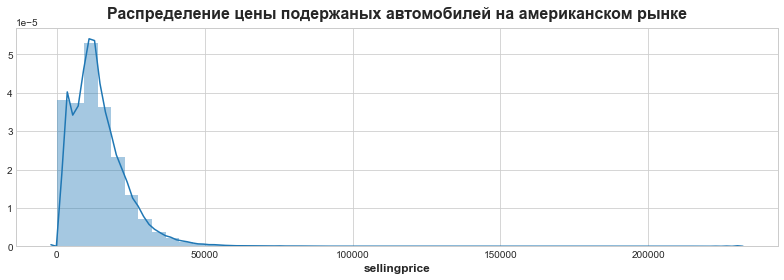

In [11]:
plt.title('Распределение цены подержаных автомобилей на американском рынке')
sns.distplot(data['sellingprice']);

Распределение цены выглядит адекватно для данныго признака. Очевидно, есть несколько супердорогих автомобилей премиальных марок.

**odometer**

In [12]:
data['odometer'].describe()

count    440167.000000
mean      68344.421604
std       53542.203908
min           1.000000
25%       28258.000000
50%       52098.000000
75%       99272.000000
max      999999.000000
Name: odometer, dtype: float64

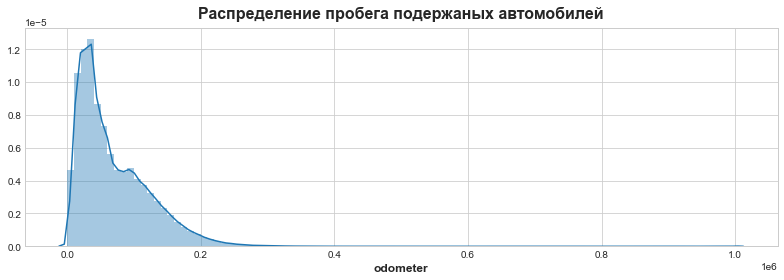

In [13]:
plt.title('Распределение пробега подержаных автомобилей')
sns.distplot(data['odometer'], bins=100);

Видно странные значения - 1 и 999999. Второе похоже на вариант обозначения пропусков/неизвестных значений.  Есть аномально маленькие и большие значения.  
Пропущенные и аномальные значения заменим медианными.

In [14]:
data.loc[data['odometer'] < 20, 'odometer'] = np.nan
data.loc[data['odometer']==999999, 'odometer'] = np.nan
data.loc[data['odometer'] > 500000, 'odometer'] = np.nan

odometer_median_train = data['odometer'].median()

data['odometer'].fillna(odometer_median_train, inplace=True)

Посмотрим на то, как соотносятся переменная odometer и целевой признак.

In [15]:
data[['sellingprice', 'odometer']].corr()

,sellingprice,odometer
sellingprice,1.000000,-0.595799
odometer,-0.595799,1.000000


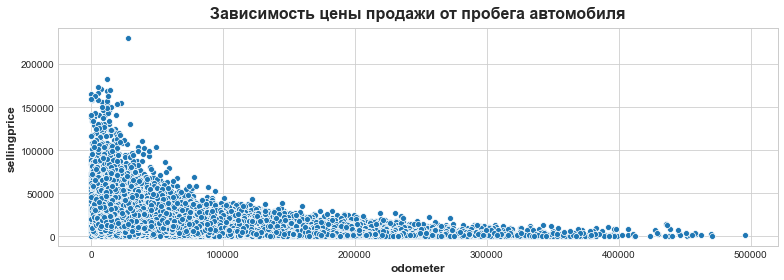

In [16]:
plt.title('Зависимость цены продажи от пробега автомобиля')
sns.scatterplot(x='odometer', y='sellingprice', data = data);

Имеется существенная линейная взаимосвязь.

**condition**

In [17]:
data['condition'].describe()

count    430831.000000
mean          3.425077
std           0.949973
min           1.000000
25%           2.700000
50%           3.600000
75%           4.200000
max           5.000000
Name: condition, dtype: float64

Аномалий не наблюдается, но есть пропуски.

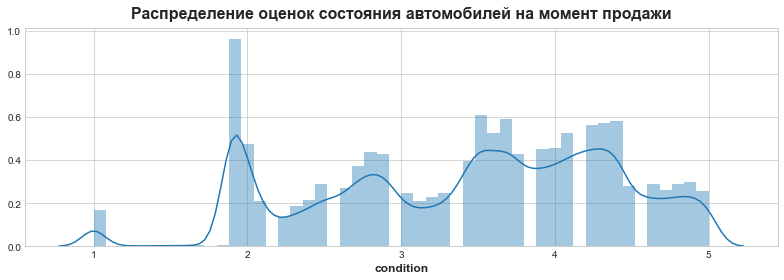

In [18]:
plt.title('Распределение оценок состояния автомобилей на момент продажи')
sns.distplot(data['condition'], bins=50);

Непонятное распределение. Пропусков, как было показано ранее, всего 2%. Заменим их средним значением.

In [19]:
condition_mean_train = data['condition'].mean()
data['condition'].fillna(condition_mean_train, inplace=True)

Смотрим на взаимодействие с целевым признаком.

In [20]:
data[['sellingprice', 'condition']].corr()

,sellingprice,condition
sellingprice,1.000000,0.532977
condition,0.532977,1.000000


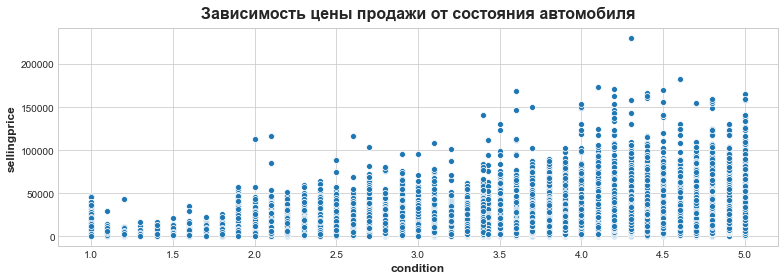

In [21]:
plt.title('Зависимость цены продажи от состояния автомобиля')
sns.scatterplot(x='condition', y='sellingprice', data = data);

Как и в случае с пробегом, достаточно высокая корреляция.

**year**

In [22]:
data['year'].describe()

count    440236.000000
mean       2010.040101
std           3.977945
min        1982.000000
25%        2007.000000
50%        2012.000000
75%        2013.000000
max        2015.000000
Name: year, dtype: float64

In [23]:
np.sort(data.year.unique())

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015])

Данные по году выпуска выглядят адекватно, скрытых дубликатов нет.

In [24]:
data[['sellingprice', 'year']].corr()

,sellingprice,year
sellingprice,1.000000,0.586847
year,0.586847,1.000000


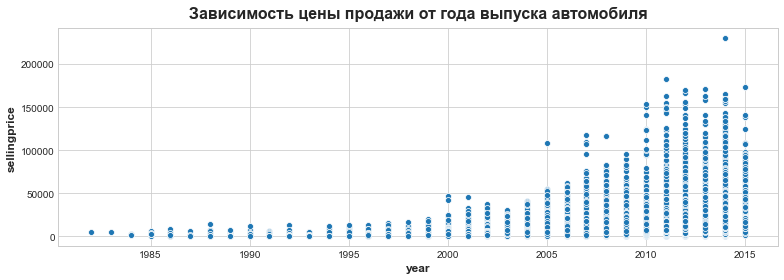

In [25]:
plt.title('Зависимость цены продажи от года выпуска автомобиля')
sns.scatterplot(x='year', y='sellingprice', data = data);

In [26]:
data[['odometer', 'condition', 'year']].corr()

,odometer,condition,year
odometer,1.000000,-0.539526,-0.792561
condition,-0.539526,1.000000,0.539004
year,-0.792561,0.539004,1.000000


Числовые признаки хорошо корреклируют с целевым, что позволяет предположить их полезность в прогнозировании. Но при этом они также скоррелированы между собой, что может стать проблемой пи применении линейных моделей.  
Перейдем к качественным характеристикам и дате продажи.

**make**

Посмотрим, есть ли скрытые дубликаты.

In [27]:
def display_unique_values(data, column):
    print('n unique values:', data[column].unique().shape[0])
    display(sorted(list(data[~data[column].isna()][column].unique())))

In [28]:
display_unique_values(data, 'make')

n unique values: 93


['Acura',
 'Aston Martin',
 'Audi',
 'BMW',
 'Bentley',
 'Buick',
 'Cadillac',
 'Chevrolet',
 'Chrysler',
 'Daewoo',
 'Dodge',
 'FIAT',
 'Ferrari',
 'Fisker',
 'Ford',
 'GMC',
 'Geo',
 'HUMMER',
 'Honda',
 'Hyundai',
 'Infiniti',
 'Isuzu',
 'Jaguar',
 'Jeep',
 'Kia',
 'Lamborghini',
 'Land Rover',
 'Lexus',
 'Lincoln',
 'MINI',
 'Maserati',
 'Mazda',
 'Mercedes-Benz',
 'Mercury',
 'Mitsubishi',
 'Nissan',
 'Oldsmobile',
 'Plymouth',
 'Pontiac',
 'Porsche',
 'Ram',
 'Rolls-Royce',
 'Saab',
 'Saturn',
 'Scion',
 'Subaru',
 'Suzuki',
 'Tesla',
 'Toyota',
 'Volkswagen',
 'Volvo',
 'acura',
 'airstream',
 'audi',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'dodge',
 'dodge tk',
 'dot',
 'ford',
 'ford truck',
 'gmc',
 'gmc truck',
 'honda',
 'hyundai',
 'jeep',
 'kia',
 'land rover',
 'landrover',
 'lexus',
 'lincoln',
 'maserati',
 'mazda',
 'mazda tk',
 'mercedes',
 'mercedes-b',
 'mercury',
 'mitsubishi',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'sma

В названиях марок автомобилей достаточно много скрытых дубликатов, вызванных разным регистром и различных написанием одних и тех же марок. Приведем все названия к одному стилю.

In [29]:
data['make'] = [m.title() if (type(m) == str) else np.nan for m in data['make']]

Теперь разбереся с разным написанием и излишней детализацией в названиях. 

In [30]:
make_dict = {'Dodge Tk':'Dodge',
            'Ford Truck':'Ford',
            'Gmc Truck':'Gmc',
            'Landrover':'Land Rover',
            'Mazda Tk':'Mazda',
            'Mercedes-B':'Mercedes',
            'Mercedes-Benz':'Mercedes',
            'Vw':'Volkswagen'}

In [31]:
data = data.replace({'make':make_dict})

Ранее мы видели, что в данном столбце есть 2% пропущенных значений. Заменим их на 'unknown'.

In [32]:
data['make'].fillna('unknown', inplace=True)

Посмотрим на медианные значения цены по группам.

In [33]:
def show_grouped_graph(column):
    grouped = data.groupby(column, as_index=False).agg({'sellingprice':'median'})
    grouped = grouped.rename(columns={'sellingprice':'median_sellingprice'}).sort_values(
    'median_sellingprice', ascending=False)
    
    sns.barplot(x='median_sellingprice', y=column, data=grouped, orient='h');

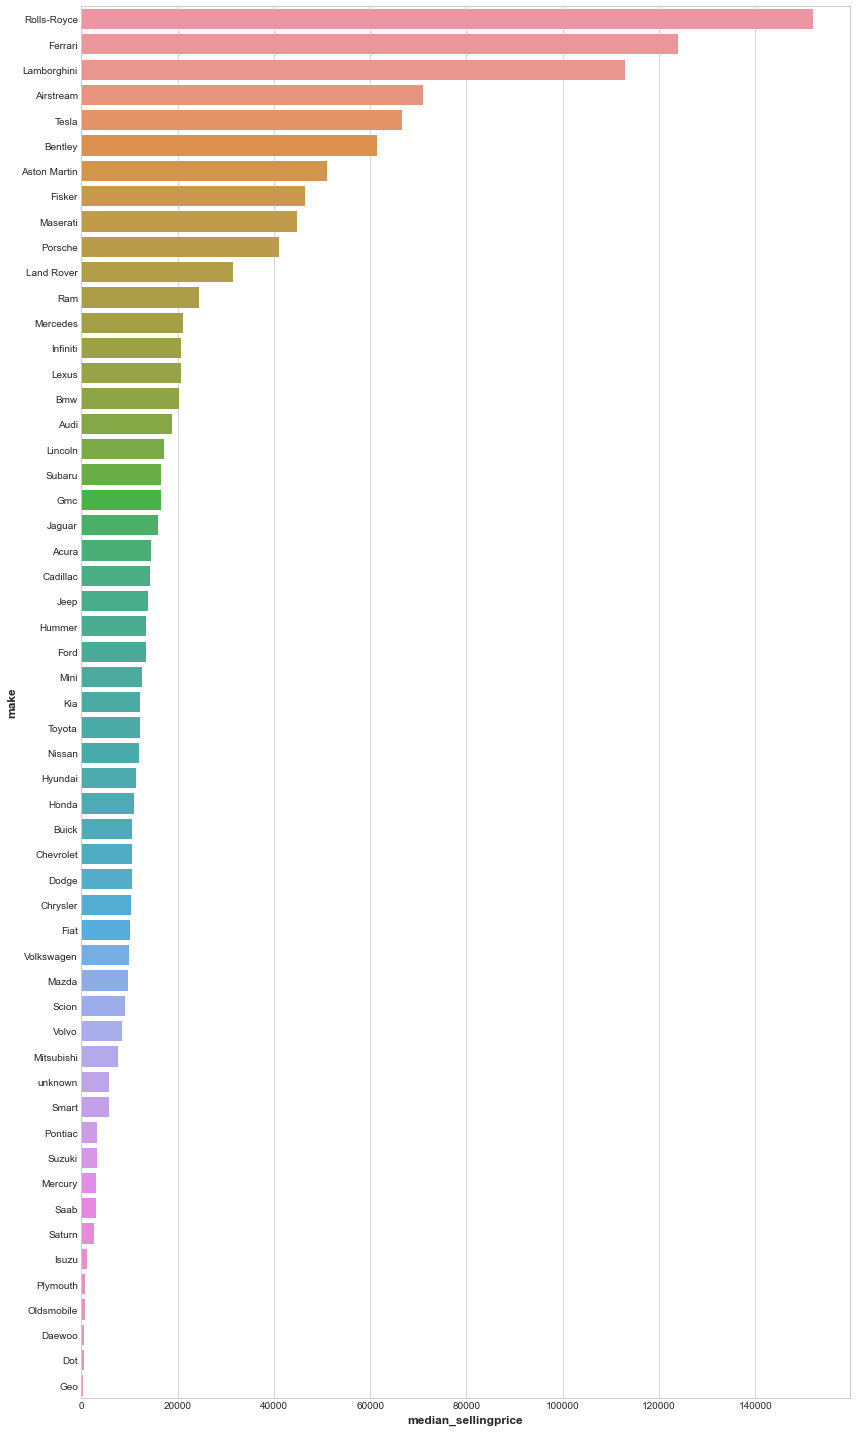

In [34]:
plt.figure(figsize=(12, 20))
show_grouped_graph('make')

Отчетливо выделяются супердорогие и премиальные марки.  
Попробуем создать и в дальнейшем использовать характеристику, выделяющую очень дорогие и очень дешевые автомобили.

In [35]:
grouped_by_make = data.groupby('make', as_index=False).agg({'sellingprice':'median'})
grouped_by_make = grouped_by_make.rename(columns={'sellingprice':'median_sellingprice'}).sort_values(
    'median_sellingprice', ascending=False)

In [36]:
def define_make_status(make):
    if make in grouped_by_make.make.values[:10]:
        return 'premium'
    if make in grouped_by_make.make.values[-11:]:
        return 'cheap'
    else: return 'other'

In [37]:
data['make_status'] = data.make.apply(define_make_status)

**model**

In [38]:
data['model'].describe()

count     432113
unique       959
top       Altima
freq       15454
Name: model, dtype: object

In [39]:
display_unique_values(data, 'model')

n unique values: 960


['1 Series',
 '1500',
 '190-Class',
 '2 Series',
 '200',
 '200SX',
 '2500',
 '3',
 '3 Series',
 '3 Series Gran Turismo',
 '300',
 '300-Class',
 '3000GT',
 '300M',
 '300ZX',
 '300e',
 '320i',
 '323i',
 '328i',
 '3500',
 '350Z',
 '350z',
 '370Z',
 '4 Series',
 '4 Series Gran Coupe',
 '400-Class',
 '420-Class',
 '420sel',
 '42c',
 '458 Italia',
 '4Runner',
 '5 Series',
 '5 Series Gran Turismo',
 '500',
 '500-Class',
 '500L',
 '500e',
 '6',
 '6 Series',
 '6 Series Gran Coupe',
 '626',
 '7',
 '7 Series',
 '750i',
 '750li',
 '750lxi',
 '8 Series',
 '850',
 '9-2X',
 '9-3',
 '9-5',
 '9-7X',
 '911',
 '940',
 '960',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'ATS',
 'Acadia',
 'Accent',
 'Accord',
 'Accord Crosstour',
 'Accord Hybrid',
 'ActiveHybrid 5',
 'ActiveHybrid 7',
 'ActiveHybrid X6',
 'Aerio',
 'Alero',
 'Altima',
 'Altima Hybrid',
 'Amanti',
 'Amigo',
 'Armada',
 'Ascender',
 'Aspen',
 'Aspire',
 'Astra',
 'Astro',
 'Astro Cargo',
 'Aura',
 'Aura Hybrid',
 'Aurora',
 'Avalanche',
 'Ava

В данных 959 уникальных названий моделей автомобилей не считая NaN. 
Заменим пропущенные значения.

In [40]:
data['model'].fillna('unknown', inplace=True)

**trim**

In [41]:
data['trim'].describe()

count     431899
unique      1922
top         Base
freq       43853
Name: trim, dtype: object

In [42]:
data['trim'].fillna('unknown', inplace=True)

In [43]:
display_unique_values(data, 'trim')

n unique values: 1923


['!',
 '& coun fwd',
 '& coun fwd limited',
 '& coun fwd lx',
 '& country lx',
 '(1999.5) XE',
 '+',
 '1',
 '1.6',
 '1.6 Base',
 '1.6 S',
 '1.6 S Plus',
 '1.6 SL',
 '1.6 SV',
 '1.8',
 '1.8 Base',
 '1.8 Krom',
 '1.8 S',
 '1.8 S Krom Edition',
 '1.8 SL',
 '1.8 TFSI Premium',
 '1.8 TFSI Premium Plus',
 '1.8T',
 '1.8T Avant quattro',
 '1.8T Classic',
 '1.8T quattro',
 '1.9',
 '10th Anniversary',
 '128i',
 '128i SULEV',
 '135i',
 '135is',
 '150 Low Roof',
 '1500',
 '1500 4x2',
 '1500 4x2 cr sle',
 '1500 4x2 cr sle1',
 '1500 4x2 ex sle',
 '1500 4x2 slt',
 '1500 4x4 cr slt',
 '1500 4x4 ex sle',
 '1500 4x4 v8 slt',
 '1500 High Roof',
 '1500 LS',
 '1500 LT',
 '1500 LT1',
 '1500 LTZ',
 '1500 Low Roof',
 '1500 Maxi',
 '1500 S',
 '1500 SLE',
 '1500 SLT',
 '1500 SV',
 '1500 awd cr denali',
 '1500 base',
 '1500 lramie slt',
 '1794',
 '1794 FFV',
 '180hp',
 '180hp quattro',
 '190E 2.3',
 '1LS Fleet',
 '1LT',
 '1LT Fleet',
 '1SS',
 '2',
 '2+2',
 '2.0',
 '2.0 S',
 '2.0 SL',
 '2.0 SR',
 '2.0 TDI Premium

Еще больше вариантов оформления салона автомобиля. Здесь я думаю преобразовать этот признак, выделив категории по содержанию слов  Limited, Base, Plus, Premium, Sport и т.д., которые могли бы дать намек на более дорогое/дешевое исполнение.

In [44]:
data['trim'] = data.trim.str.lower()

In [45]:
def trim_feature(trim):
    if trim.find('limited') != -1: return 'limited'
    elif trim.find('base') != -1: return 'base'
    elif trim.find('plus') != -1: return 'plus'
    elif trim.find('premium') != -1: return 'premium'
    elif trim.find('anniversary') != -1: return 'anniversary'
    elif trim.find('prestige') != -1: return 'prestige'
    elif trim.find('sport') != -1: return 'sport'
    elif trim.find('turbo') != -1: return 'turbo'
    elif trim.find('special') != -1: return 'special'
    elif trim.find('advance') != -1: return 'advance'
    elif trim.find('luxury') != -1: return 'luxury'
    elif trim.find('super') != -1: return 'super'
    elif trim.find('deluxe') != -1: return 'deluxe'
    else: return 'other'

In [46]:
data['trim_feature'] = data['trim'].apply(trim_feature)

**body**

In [47]:
data['body'].describe()

count     429843
unique        85
top        Sedan
freq      157639
Name: body, dtype: object

In [48]:
data['body'].fillna('other', inplace=True)

In [49]:
display_unique_values(data, 'body')

n unique values: 86


['Access Cab',
 'Beetle Convertible',
 'CTS Coupe',
 'CTS Wagon',
 'CTS-V Coupe',
 'CTS-V Wagon',
 'Cab Plus',
 'Cab Plus 4',
 'Club Cab',
 'Convertible',
 'Coupe',
 'Crew Cab',
 'CrewMax Cab',
 'Double Cab',
 'E-Series Van',
 'Elantra Coupe',
 'Extended Cab',
 'G Convertible',
 'G Coupe',
 'G Sedan',
 'G37 Convertible',
 'G37 Coupe',
 'Genesis Coupe',
 'GranTurismo Convertible',
 'Hatchback',
 'King Cab',
 'Koup',
 'Mega Cab',
 'Minivan',
 'Promaster Cargo Van',
 'Q60 Convertible',
 'Q60 Coupe',
 'Quad Cab',
 'Ram Van',
 'Regular Cab',
 'SUV',
 'Sedan',
 'SuperCab',
 'SuperCrew',
 'TSX Sport Wagon',
 'Transit Van',
 'Van',
 'Wagon',
 'Xtracab',
 'access cab',
 'beetle convertible',
 'cab plus 4',
 'club cab',
 'convertible',
 'coupe',
 'crew cab',
 'crewmax cab',
 'cts coupe',
 'cts-v coupe',
 'double cab',
 'e-series van',
 'elantra coupe',
 'extended cab',
 'g convertible',
 'g coupe',
 'g sedan',
 'g37 convertible',
 'g37 coupe',
 'genesis coupe',
 'granturismo convertible',
 'hatc

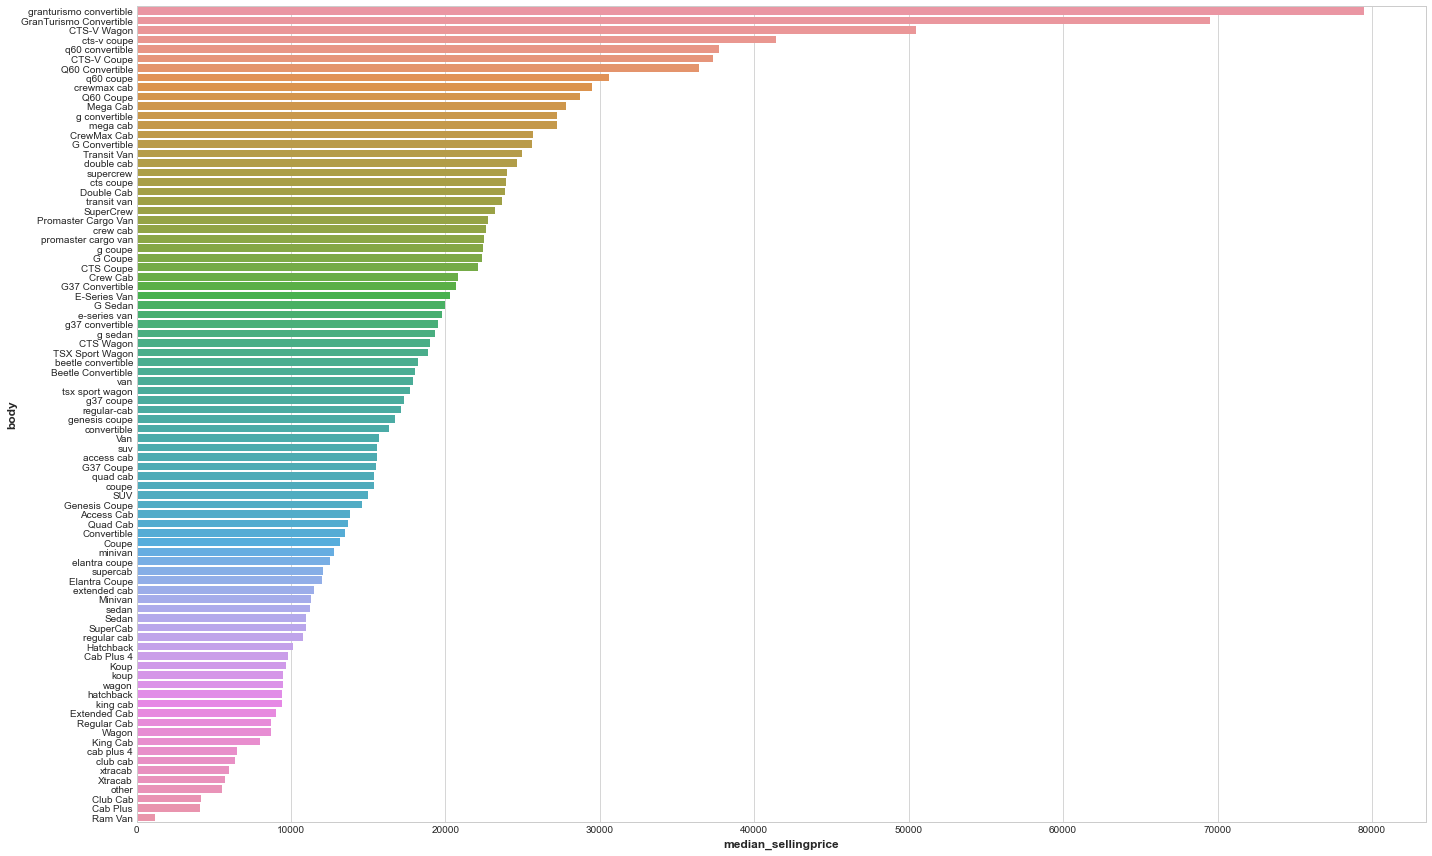

In [50]:
plt.figure(figsize=(20,12))
show_grouped_graph('body')

86 уникальных значений. Возможно, будет полезным их унифицировать.

In [51]:
data['body'] = data['body'].str.lower()

In [52]:
def body_unified(body):
    if body.find('cab') != -1: return 'cab'
    elif body.find('convertible') != -1: return 'convertible'
    elif body.find('coupe') != -1 or body.find('koup') != -1: return 'coupe'
    elif body.find('wagon') != -1: return 'wagon'
    elif body.find('minivan') != -1: return 'minivan'
    elif body.find('van') != -1: return 'van'
    elif body.find('suv') != -1: return 'suv'
    elif body.find('sedan') != -1: return 'sedan'
    else: return 'other'

In [53]:
data['body_unified'] = data['body'].apply(body_unified)

**transmission**

In [54]:
data['transmission'].describe()

count        388775
unique            2
top       automatic
freq         375061
Name: transmission, dtype: object

In [55]:
display_unique_values(data, 'transmission')

n unique values: 3


['automatic', 'manual']

С коробками передач все хорошо, но есть пропуски. Заменим их наиболее часто встречающимся значением.

In [56]:
transmission_mode_train = data.transmission.mode()[0]

In [57]:
data['transmission'].fillna(transmission_mode_train, inplace=True)

**state**

In [58]:
data['state'].describe()

count     440236
unique        38
top           fl
freq       65618
Name: state, dtype: object

In [59]:
display_unique_values(data, 'state')

n unique values: 38


['ab',
 'al',
 'az',
 'ca',
 'co',
 'fl',
 'ga',
 'hi',
 'il',
 'in',
 'la',
 'ma',
 'md',
 'mi',
 'mn',
 'mo',
 'ms',
 'nc',
 'ne',
 'nj',
 'nm',
 'ns',
 'nv',
 'ny',
 'oh',
 'ok',
 'on',
 'or',
 'pa',
 'pr',
 'qc',
 'sc',
 'tn',
 'tx',
 'ut',
 'va',
 'wa',
 'wi']

Штаты выглядят хорошо, проусков нет.

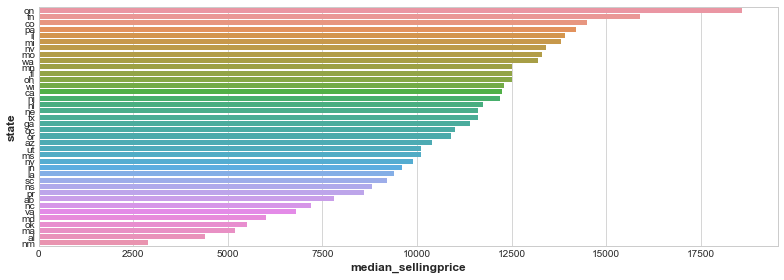

In [60]:
show_grouped_graph('state')

**color**

In [61]:
data['color'].describe()

count     439650
unique        20
top        black
freq       87115
Name: color, dtype: object

In [62]:
display_unique_values(data, 'color')

n unique values: 21


['beige',
 'black',
 'blue',
 'brown',
 'burgundy',
 'charcoal',
 'gold',
 'gray',
 'green',
 'lime',
 'off-white',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'turquoise',
 'white',
 'yellow',
 '—']

Дубликатов нет (как показал словарь, off-white это кремовый). Пропуски в виде "-", думаю, лучше заменить на "unknown".

In [63]:
data['color'] = data['color'].replace('—', 'unknown')
data['color'].fillna('unknown', inplace=True)

**interior**

In [64]:
data['interior'].describe()

count     439650
unique        17
top        black
freq      192442
Name: interior, dtype: object

In [65]:
display_unique_values(data, 'interior')

n unique values: 18


['beige',
 'black',
 'blue',
 'brown',
 'burgundy',
 'gold',
 'gray',
 'green',
 'off-white',
 'orange',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow',
 '—']

Этот признак обработаем аналогично color.

In [66]:
data['interior'] = data['interior'].replace('—', 'unknown')
data['interior'].fillna('unknown', inplace=True)

**seller**

In [67]:
data['seller'].describe()

count                 440236
unique                 13025
top       nissan-infiniti lt
freq                   15823
Name: seller, dtype: object

In [68]:
display_unique_values(data, 'seller')

n unique values: 13025


['1 cochran of monroeville',
 '1 for all auto sales',
 '1360250 alberta ltd.',
 '138 auto inc',
 '143 auto sales inc',
 '1479582 alberta ltd.',
 '1491081 alberta inc.',
 '1555357 alberta limited',
 '159191 canada inc',
 '1764175 alberta ltd',
 '1770144 alberta ltd',
 '1813477 alberta ltd',
 '1814099 alberta ltd',
 '1995 first avenue station',
 '1st advantage fcu',
 '1st canadian auto sales & service',
 '1st capital finance',
 '1st choice automotive corp',
 '1st choice credit union',
 '1st choice money center',
 '1st class auto',
 '1st commercial',
 '1st financial fcu',
 '1st liberty fcu',
 '1st liberty federal credit union',
 '1st mid america credit union',
 '1st national bank of scotia',
 '1st security of st pete inc',
 '1st source bank',
 '2 fran-nick auto sales llc',
 '2020 motors',
 '22nd street motors inc',
 '231 car sales,inc.',
 '24-7 auto sales llc',
 '25th street auto sales',
 '2626 5660 quebec inc',
 '281 truck sales',
 '2842 2988 quebec inc',
 '2970 7528 quebec inc',
 '2nd c

Пропусков нет, но очень много уникальных знаечний, даже если поработать со скрытыми дубликатами. Возможно, какую-то информацию можно вытащить опираясь на слова affordable, luxury и т.п., которые могут отражать ценовую политику продавца.  


In [69]:
def seller_feature(seller):
    if seller.find('affordable') != -1: return 'affordable'
    elif seller.find('luxury') != -1: return 'luxury'
    elif seller.find('elite') != -1: return 'elite'
    elif seller.find('exotic') != -1: return 'exotic'
    else: return 'other'

In [70]:
data['seller_feature'] = data['seller'].apply(seller_feature)

**saledate**

In [71]:
data['saledate'].describe()

count                        440236
unique                         3597
top       2015-02-09 17:30:00+00:00
freq                           4209
first     2014-01-01 01:15:00+00:00
last      2015-07-20 19:30:00+00:00
Name: saledate, dtype: object

Пропусков нет.  
Сформируем дополнительные признаки на основе даты продажи.

In [72]:
data['saleyear'] = data['saledate'].dt.year 
data['salemonth'] = data['saledate'].dt.month
data['saleday'] = data['saledate'].dt.day

Сформируем еще один признак - возраст автомобиля как разницу между годом выпуска и годом продажи.

In [73]:
data['age'] = data['saleyear'] - data['year']

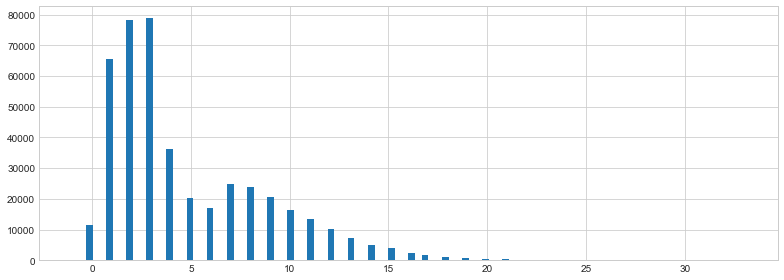

In [74]:
data['age'].hist(bins=100);

Здесь выявляется аномалия: некоторые машины получились моложе своего года выпуска.  
Вероятно, неверно заполнен год выпуска. Посколку ситуация, когда купленный новый автомобиль продают в тот же год, не является нереальной, заменим год выпуска на года продажи у таких автомобилей.

In [75]:
data.loc[data['age']<0, 'year'] = data.loc[data['age']<0, 'saleyear']
data.loc[data['age']<0, 'age'] = 0

Возможно, будет полезным еще один признак - пробег в год, который будет отражать интенсивность использования автомобиля.

In [76]:
data['miles_per_year'] = (data['odometer']/data['age']).where(
    data['age']!=0, other=data['odometer'])

Теперь напишем функцию, которая проведет все аналогичные преобразования с тестовыми данными.

In [77]:
def prepare_test_data(df):
    
    df['saledate'] = pd.to_datetime(df['saledate'], utc=True)
    
    df['make'] = [m.title() if (type(m) == str) else np.nan for m in df['make']]
    df = df.replace({'make':make_dict})
    
    df[['color', 'interior']] = df[['color', 'interior']].replace('—', 'unknown')
    
    df.loc[df['odometer']<20, 'odometer'] = np.nan
    df.loc[df['odometer']==999999, 'odometer'] = np.nan
    df.loc[df['odometer']>500000, 'odometer'] = np.nan
    
    df['saleyear'] = df['saledate'].dt.year
    df['age'] = df['saleyear'] - df['year']
    df.loc[df['age']<0, 'year'] = df.loc[df['age']<0, 'saleyear']
    df.loc[df['age']<0, 'age'] = 0
    
    df['odometer'].fillna(odometer_median_train, inplace=True)
    df['condition'].fillna(condition_mean_train, inplace=True)
    
    for col in ['make', 'model', 'trim', 'body', 'color', 'interior']:
        df[col].fillna('unknown', inplace=True)
    df['transmission'].fillna('transmission_mode_train', inplace=True)
    
    df['salemonth'] = df['saledate'].dt.month
    df['saleday'] = df['saledate'].dt.day
    
    df['make_status'] = df.make.apply(define_make_status)
    df['body_unified'] = df['body'].apply(body_unified)
    
    df['trim_feature'] = df['trim'].apply(trim_feature)
    
    df['miles_per_year'] = (df['odometer']/df['age']).where(
    df['age']!=0, other=df['odometer'])
    
    return df

<a id='step3'></a>
## 3. Подготовка итоговых признаков для обучения модели
[к содержанию](#contence)

Попробуем выяснить важность признаков для предсказания целевого. Для этого будем использовать показатель взаимной информации, чтобы обнаружить не только линейную взаимосвязь.

In [78]:
X = data.copy()
y = X.pop('sellingprice')

In [79]:
X = X.drop('saledate',axis=1)

In [80]:
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [81]:
discrete_features = X.dtypes == int

In [82]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [83]:
mi_scores = make_mi_scores(X, y, discrete_features)

In [84]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [85]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Наиболее информативными оказались модель, продавец и уровень оформления салона автомобиля. Сгенерированные мной дополнительные признаки сильно проигрывают.  
Доалее попробуем использовать первые 10 наиболее информативных признаков.

<a id="step4"></a>
## 4. Обучение моделей и формирование предсказаний
[К содержанию](#contence)

Как уже было сказано, возьмем топ 10 наиболее важных признаков по критерию взаимной информации.

In [86]:
features_train = data[['model', 'seller', 'trim', 'year', 'age', 'odometer',
                       'condition', 'make', 'body', 'state']]
target_train = data['sellingprice']

In [87]:
cat_features = ['model', 'seller', 'trim', 'make', 'body', 'state']
num_features = ['year', 'age', 'odometer', 'condition']

Целевая метрика в данной задаче  - MAPE.

In [88]:
scorer = make_scorer(mean_absolute_percentage_error)

Прочитаем тестовые данные и напишем функцию для формирования предсказаний и csv - файла для заливки результата на Kaggle.

In [89]:
test_data = pd.read_csv('used-cars-price-prediction-19ds/test.csv', index_col='vin')

In [90]:
test_features = prepare_test_data(test_data)

In [91]:
def make_test_predictions(model, test_features, filename):
    test_features = test_features[features_train.columns]
    predictions = model.predict(test_features)
    result_df = pd.DataFrame(index=test_features.index, columns=['sellingprice'], data=predictions)
    result_df.to_csv(filename)

**Lasso регрессия**

Попробудем модель Lasso, которая позволяет отобрать неинформативные признаки и решить проблему с коррелирующими между собой признаками.

In [92]:
model_lasso = Lasso(random_state=RANDOM_STATE)

In [93]:
col_transformer_linear = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999), cat_features),
    (MinMaxScaler(),
    num_features),
    remainder='passthrough')

In [94]:
pipeline_lasso = make_pipeline(col_transformer_linear,
                           model_lasso)

In [95]:
param_grid_lasso = {'lasso__alpha':[0,0.001,0.01,0.1,1,10]}

In [96]:
rs_lasso = RandomizedSearchCV(pipeline_lasso,
                    param_distributions=param_grid_lasso,
                    n_iter=40,
                    scoring=scorer,
                    n_jobs=-1, 
                    random_state=RANDOM_STATE)

In [97]:
rs_lasso.fit(features_train, target_train)

In [98]:
rs_lasso.best_params_

In [99]:
rs_lasso.best_score_

Качество получилось плохим (0.8244). Посмотрим, какие характеристики модель считает важными:

In [100]:
importances = rs_lasso.best_estimator_.named_steps['lasso'].coef_
imp = list(zip(features_train.columns, importances))

In [101]:
imp.sort(key = lambda t:abs(t[1]), reverse=True)
imp

Видно, что модель ориентировалась на тип кузова, оценку состояния и штат, что не совпадает с выводами, сделанными по показателю взаимной информации. При этом совсем зануляется производитель, что кажется нелогичным потому как цена у разных производителей очень сильно различается.

**Elastic net**

Далее попробуем модель ElasticNet, которая позволяет применить и L1 и L2 - регуляризацию.

In [102]:
model_elastic = ElasticNet(random_state=RANDOM_STATE)

In [103]:
pipeline_elastic = make_pipeline(col_transformer_linear,
                           model_elastic)

In [104]:
param_grid_elastic = {'elasticnet__alpha':[0,0.001,0.01,0.1,1,10],
                     'elasticnet__l1_ratio':[0,0.25,0.5,0.75,1]}

In [105]:
rs_elastic = RandomizedSearchCV(pipeline_elastic,
                    param_distributions=param_grid_elastic,
                    n_iter=40,
                    scoring=scorer,
                    n_jobs=-1, 
                    random_state=RANDOM_STATE)

In [106]:
rs_elastic.fit(features_train, target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=99999),
                                                                               ['model',
                                                                                'seller',
                                                                                'trim',
                                                                                'make',
                                                                                'body',
                                                                                'state']),
                                                                              ('minmaxscaler',
                                                                               MinMaxScaler(),
                                                                               ['year',
                                                                                'age',
                                                                                'odometer',
                                                                                'condition'])])),
                                             ('elasticnet',
                                              ElasticNet(random_state=42))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'elasticnet__alpha': [0, 0.001, 0.01,
                                                              0.1, 1, 10],
                                        'elasticnet__l1_ratio': [0, 0.25, 0.5,
                                                                 0.75, 1]},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_percentage_error))

In [107]:
rs_elastic.best_params_

{'elasticnet__l1_ratio': 0, 'elasticnet__alpha': 10}

In [108]:
rs_elastic.best_score_

1.9276201336718255

Все стало гораздо хуже (MAPE на кросс-валидации составляет 1.9276). По всей видимости, линейные модели не очень хорошо подходят для решения данной задачи. Попробуем модель решающего дерева.

**DecisionTreeRegressor**

In [109]:
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [94]:
col_transformer_trees = make_column_transformer(
(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999), cat_features),
remainder='passthrough')

In [111]:
pipeline_tree = make_pipeline(col_transformer_trees,
                           model_tree)

In [112]:
param_grid_tree = {'decisiontreeregressor__max_depth': range(30, 80)}

In [113]:
rs_tree = RandomizedSearchCV(pipeline_tree,
                   param_distributions=param_grid_tree,
                   n_iter=40,
                   scoring=scorer,
                   n_jobs=-1, 
                   random_state=RANDOM_STATE)

In [114]:
rs_tree.fit(features_train, target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=99999),
                                                                               ['model',
                                                                                'seller',
                                                                                'trim',
                                                                                'make',
                                                                                'body',
                                                                                'state'])])),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': range(30, 80)},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_percentage_error))

In [115]:
rs_tree.best_params_

{'decisiontreeregressor__max_depth': 49}

In [116]:
rs_tree.best_score_

0.28409750905410946

Результат на кросс-валидации значительно улучшился (0.2841), но при загрузке тестового результата на kaggle выяснилось, что модель сильно переобучается, т.к. тестовая MAPE составила больше 100.  
Попробуем использовать случайный лес. 

**RandomForest**

In [92]:
model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

In [95]:
pipeline_forest = make_pipeline(col_transformer_trees,
                           model_forest)

In [96]:
param_grid_forest = {'randomforestregressor__n_estimators': range(50, 201, 50), 
                     'randomforestregressor__max_depth': range(10, 50)}

In [97]:
rs_forest = RandomizedSearchCV(pipeline_forest,
                   param_distributions=param_grid_forest,
                   n_iter=40,
                   scoring=scorer,
                   n_jobs=-1, 
                   random_state=RANDOM_STATE)

In [98]:
rs_forest.fit(features_train, target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=99999),
                                                                               ['model',
                                                                                'seller',
                                                                                'trim',
                                                                                'make',
                                                                                'body',
                                                                                'state'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(10, 50),
                                        'randomforestregressor__n_estimators': range(50, 201, 50)},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_percentage_error))

In [99]:
rs_forest.best_params_

{'randomforestregressor__n_estimators': 150,
 'randomforestregressor__max_depth': 10}

In [100]:
rs_forest.best_score_

0.37040619011437376

Качество на кросс-валидации снизилось, но при этом значительно снизтлась и проблема переобучения. На тестовых данных качество модели составило 0.4426065.

In [101]:
importances_forest = rs_forest.best_estimator_.named_steps[
    'randomforestregressor'].feature_importances_

In [102]:
imp_forest = list(zip(features_train.columns, importances_forest))

In [103]:
imp_forest.sort(key = lambda t:abs(t[1]), reverse=True)

In [104]:
imp_forest

[('body', 0.46836912354000715),
 ('age', 0.15418927308542033),
 ('year', 0.12688869574919903),
 ('condition', 0.0814437138375471),
 ('model', 0.059671090790075515),
 ('trim', 0.05154155655819395),
 ('state', 0.04980255361229507),
 ('make', 0.005817835852873061),
 ('seller', 0.001994987376419045),
 ('odometer', 0.00028116959796981207)]

Для модели случайного леса наиболее важными оказались тип кузова, возраст и год выпуска.

<a id='step6'></a>
## 5. Вывод
[К содержанию](#contence)

В данной работе решалась задача разработки модели предсказания цены подержаного автомобиля на американском рынке.  
Для анализа использовались как числовые характеристики (пробег, оценка состояния), так и качественные показатели, характеризующие марку и модель, а также внешнее и внутреннее оформление автомобиля и штат, в котором происходила продажа.  Также были доступны год выпуска транспортного средства и дата продажи.  
В ходе предобработки были выявлены и устранены неявные дубликаты, заполнены пропуски, сформированы новые признаки, изучено взаимодействие характеристик с целевым признаком.  
Производя первоначальный отбор признаков, я ориентировалась на величину взаимной информации признаков с целевой переменной. Наиболее важными с этой точки зрения оказались модель, продавец и уровень отделки салона.  
Для дальнейшего моделирования были выбраны топ-10 характеристик по показателю взаимной информации.  
Для решения задачи регрессии были рассмотрены линейные модели (Lasso и ElasticNet), а также решающее дерево и случайный лес. Наибольшее значение метрики MAPE на тестовых данных показал алгоритм RandomForestRegressor.